# Customer Segmentation

We will be using E-commerce dataset of user purchases and try develop a model that allow us to do two things:

1. Classifying customers into segments.
2. Anticipate the purchases that will be made by a new customer, during the following year and 
   this, from its first purchase by assigning them appropriate cluster/segment 


## ** Import dependancies **

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk
import matplotlib.cm as cm
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA

%matplotlib inline

## **  Data Preparation **

In [2]:
# read the datafile
df_initial = pd.read_csv('./input_data/data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

Dataframe dimensions: (541909, 8)


In [3]:
# show first lines
df_initial[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [4]:
# show last lines
df_initial[-5:]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680,France


So the data is for 2010-11

## **  Exploratory Data Analysis **

### Variable Identification

In [5]:
# Variables

print(f"{len(df_initial.columns)} variables are {", ".join(list(df_initial.columns))} ")

8 variables are InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country 


In [6]:
# Data types

print(df_initial.dtypes)

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object


In [7]:
# create month/year column
df_initial['Month/Year'] = df_initial["InvoiceDate"].apply(lambda x: x.strftime('%m/%Y'))

In [8]:
# Categorical Values

cat_cols = df_initial.select_dtypes(include=['category', 'object']).columns
size = len(cat_cols)
print(f"{size} Obejcts or Categorical Columns are {", ".join(cat_cols)}")
del size

6 Obejcts or Categorical Columns are InvoiceNo, StockCode, Description, CustomerID, Country, Month/Year


### Univariate Analysis

##### 1) For Categorical Values

In [9]:
# Frequency Table each Object
print("Number of unique features in :\n")
for cat in cat_cols:
    print(f"{cat} -> {df_initial[cat].nunique()}")
    

Number of unique features in :

InvoiceNo -> 25900
StockCode -> 4070
Description -> 4223
CustomerID -> 4372
Country -> 38
Month/Year -> 13


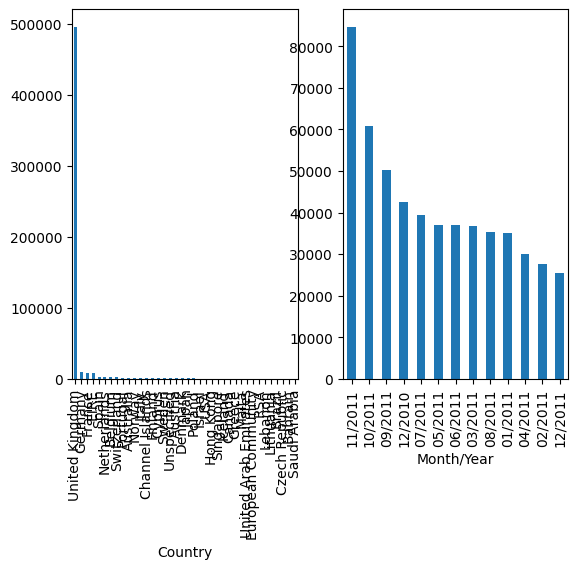

In [10]:
# Percentage Table skipped
# Bar Chart for each Object
def plot_category_frequency(df, cols, sort_index=False):
    for i, cat in enumerate(cols):
        plt.subplot(
            (len(cols) + 1) // 2,  # Calculate rows: `(len(cols) + 1) // 2`
            2,                    # Number of columns fixed at 2
            i + 1                 # Plot index starts at 1
        )
        if(sort_index): df[cat].value_counts().sort_index().plot(kind='bar')
        else: df[cat].value_counts().plot(kind='bar')

plot_category_frequency(df_initial, ["Country", "Month/Year"])

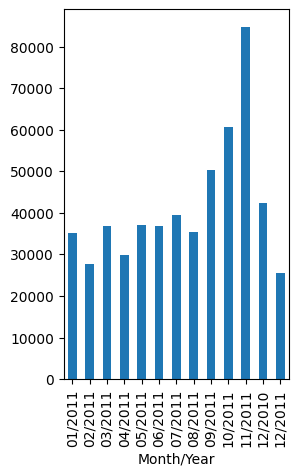

In [11]:
plot_category_frequency(df_initial, ["Month/Year"], sort_index=True)

Country is definetly a Categorical Value
StockCode has to be regarded as categorical

Note: if numebrs dont have relative realtionship, it should be tried to be categorical values. Feature should represent a meaningful category or group relevant to the analysis or mode

Most of transactions data are from UK, which is obvious
Month/Year also gives some insight aobut data, like October's transactions peaks in 2011

##### 2) For left Continous Values

In [12]:
# Histogram for left Continuous Values

# def plot_histogram(df, cols):
#     for i, cat in enumerate(cols):
#         plt.subplot((len(cols)+1)//2 ,2, i+1)
#         df[cat].hist(bins=30)
      
# plot_histogram(df_initial, ['InvoiceNo'])

### Bi Variate Analysis -> Skipped!

### Identify null values

In [13]:
# gives some infomation on columns types and number of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=pd.concat([tab_info, pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'})])
tab_info=pd.concat([tab_info,pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.rename(index={0:'null values (%)'})])

print ('-' * 10 + " Display information about column types and number of null values " + '-' * 10 +'\n')

tab_info


---------- Display information about column types and number of null values ----------



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month/Year
column type,object,object,object,int64,datetime64[ns],float64,object,object,object
null values (nb),0,0,1454,0,0,0,135080,0,0
null values (%),0.0,0.0,0.268311,0.0,0.0,0.0,24.926694,0.0,0.0


### Remove data entries 
Note: 
 * If you are looking to the CustomerID column then there are 25% data entries are   
   null.
 * That means there are 25% of data entries which aren't assigned to the any 
   customer(s).
 * It is impossible for us to map values for the customer and these entries. These is 
   usless for the current exercise.
 * Because of all the above points we are deleting these data entries.


In [14]:
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)
# gives some information on columns types and number of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=pd.concat([tab_info, pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'})])
tab_info=pd.concat([tab_info,pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.rename(index={0:'null values (%)'})])
display(tab_info)

Dataframe dimensions: (406829, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month/Year
column type,object,object,object,int64,datetime64[ns],float64,object,object,object
null values (nb),0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
print('Duplicate data entries: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Duplicate data entries: 5225


### Exploring data attributes
---

#### ** Exploring the data attribute : Country **

In [16]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(                                      # Note: First I chose 3 columns, then groupby (in the order specified) -> this is only for visual ease. 
    ['CustomerID', 'InvoiceNo', 'Country']).count()                                                     # Now I counted each value each combination (of columns), which made them index. Now since there are no 
temp = temp.reset_index(drop = False)                                                                   # other columns besides specified columns which are used to make index, the resulting size of columns = 0, as all columns are turned to index
countries = temp['Country'].value_counts()
print('No. of countries in dataframe: {}'.format(len(countries)))


No. of countries in dataframe: 37


In [17]:
temp_no_of_order_per_count = df_initial[['CustomerID','Country']].groupby(['Country']).count()
temp_no_of_order_per_count = temp_no_of_order_per_count.reset_index(drop = False)

print('-' * 10 + " Contry-wise order calculation "+ '-' * 10 + "\n")
print
print (temp_no_of_order_per_count.sort_values(
    by='CustomerID', ascending=False).rename(index=str,
                                        columns={"CustomerID": "Country wise number of order"}))

---------- Contry-wise order calculation ----------

                 Country  Country wise number of order
35        United Kingdom                        356728
14               Germany                          9480
13                France                          8475
10                  EIRE                          7475
30                 Spain                          2528
23           Netherlands                          2371
3                Belgium                          2069
32           Switzerland                          1877
26              Portugal                          1471
0              Australia                          1258
24                Norway                          1086
18                 Italy                           803
6        Channel Islands                           757
12               Finland                           695
7                 Cyprus                           611
31                Sweden                           461
1           

#### ** Exploring the data attribute : Customers and products **

The dataframe contains $\sim$400,000 entries. What are the number of users and products in these entries ?

In [18]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], 
              index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


As you can see that this dataset contain the recods of 4372 users who bought 3684 different items.
There are $\sim$22,000 transactions which are carried out.

Now we need to explore the number of products purchased in every transaction

In [19]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()            # InvoiceDate is chosen as it is unique -> it will effectivly give count of Combinations of CustomerID & InvoiceNo
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


Points to be noted here: 

* There are some users who bought only comes one time on the E-commerce platform and purchased one   
  item. The example of this kind of user is customerID 12346.  

* There are some users who frequently buy large number of items per order. The example of this kind of 
  user is customerID 12347.  

* If you notice Invoiceno data attribute then you can find out that there is prefix 'C' for one 
  invoice. This 'C' indicates that the particular transaction has been cancelled.

#### ** Analysis of cancelled orders **

We need to count the number of transactions corresponding to cancelled orders

In [20]:
nb_products_per_basket['order_cancelled'] = nb_products_per_basket['InvoiceNo'].apply(
    lambda x:int('C' in x))
display(nb_products_per_basket[:5])


n1 = nb_products_per_basket['order_cancelled'].sum()
n2 = nb_products_per_basket.shape[0]
percentage = (n1/n2)*100
print('Number of orders cancelled: {}/{} ({:.2f}%) '.format(n1, n2, percentage))

,CustomerID,InvoiceNo,Number of products,order_cancelled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders cancelled: 3654/22190 (16.47%) 


Note that the number of cancelled transactions are quite large ( $\sim$16% of the total number of transactions). 

Now, let's look at the first few lines of the dataframe

In [21]:
display(df_initial.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month/Year
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,01/2011
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom,01/2011
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland,08/2011
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland,01/2011
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland,12/2010


From the above output, we see that when an order is canceled, we have another transactions in the dataframe, mostly identical except for the **Quantity** and **InvoiceDate** variables. I decide to check if this is true for all the entries.
To do this, I decide to locate the entries that indicate a negative quantity and check if there is *systematically* an order indicating the same quantity (but positive), with the same description (**CustomerID**, **Description** and **UnitPrice**):

In [22]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


/tmp/ipykernel_8461/2472347825.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1])
/tmp/ipykernel_8461/2472347825.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  & (df_initial['Description'] == col[2])].shape[0] == 0:


We see that the initial hypothesis is not fulfilled because of the existence of a  '_Discount_' entry. I check again the hypothesis but this time discarding the '_Discount_' entries:

In [23]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


/tmp/ipykernel_8461/2431417751.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1])
/tmp/ipykernel_8461/2431417751.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  & (df_initial['Description'] == col[2])].shape[0] == 0:


Once more, we find that the initial hypothesis is not verified. Hence, cancellations do not necessarily correspond to orders that would have been made beforehand.

At this point, I decide to create a new variable in the dataframe that indicate if part of the command has been canceled. For the cancellations without counterparts, a few of them are probably due to the fact that the buy orders were  performed before December 2010 (the point of entry of the database). Below, I make a census of the cancel orders and check for the existence of counterparts:

In [24]:
# Removal of Both -> Ordered & Cancelled in Dataset date range + Cancelled only in Dataset Date range (means ordered before 2010 December)

df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()

    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
   
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
   
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

In the above function, I checked the two cases:
1. a cancel order exists without counterpart
2. there's at least one counterpart with the exact same quantity

The index of the corresponding cancel order are respectively kept in the `doubtfull_entry` and `entry_to_remove` lists whose sizes are:

In [25]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7521
doubtfull_entry: 1226


Among these entries, the lines listed in the doubtfull_entry list correspond to the entries indicating a cancellation but for which there is no command beforehand. In practice, I decide to delete all of these entries, which count respectively for $\sim$ 1.4% and 0.2% of the dataframe entries.

Now I check the number of entries that correspond to cancellations and that have not been deleted with the previous filter:

In [26]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month/Year,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,01/2011,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,02/2011,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,03/2011,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,03/2011,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,03/2011,0


If one looks, for example, at the purchases of the consumer of one of the above entries and corresponding to the same product as that of the cancellation, one observes:

In [27]:
df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month/Year,QuantityCanceled


We see that the quantity canceled is greater than the sum of the previous purchases.

---

#### **Analysis of the StockCode**

Above, it has been seen that some values of the ** StockCode ** variable indicate a particular transaction (i.e. D for _Discount_). I check the contents of this variable by looking for the set of codes that would contain only letters:

In [28]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [29]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


We see that there are several types of peculiar transactions, connected e.g. to port charges or bank charges.


___
#### Analysis of Basket Price


I create a new variable that indicates the total price of every purchase:

In [30]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month/Year,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,01/2011,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,04/2011,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347,Iceland,10/2011,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347,Iceland,10/2011,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,10/2011,0,35.7


Each entry of the dataframe indicates prizes for a single kind of product. Hence, orders are split on several lines. I collect all the purchases made during a single order to recover the total order prize:

In [31]:

# sum of purchases / user & order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

# date of the order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# selection of significant entries
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000000000
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:43:00.000000000
4,12347,556201,382.52,2011-06-09 13:01:00.000000000
5,12347,562032,584.91,2011-08-02 08:48:00.000000000
6,12347,573511,1294.32,2011-10-31 12:25:00.000000000


In order to have a global view of the type of order performed in this dataset, I determine how the purchases are divided according to total prizes:

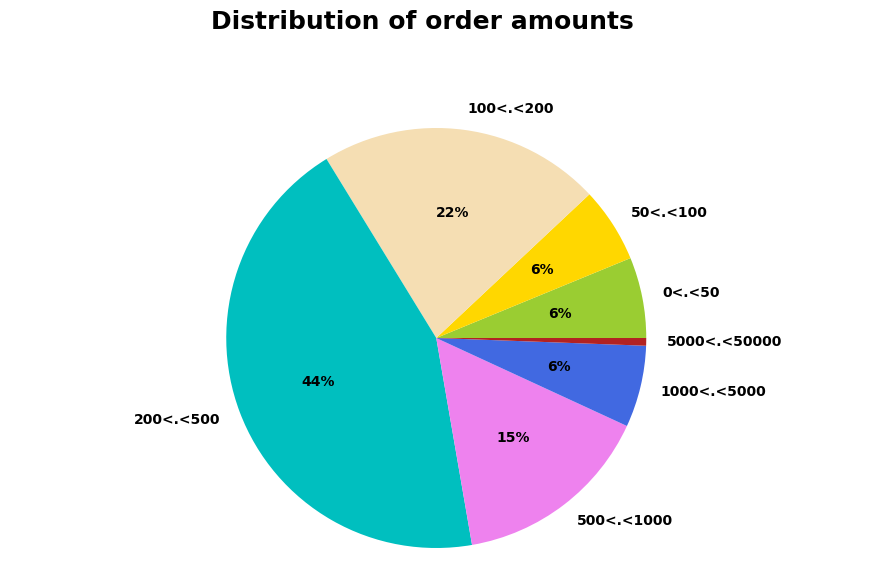

In [32]:
# Purchase count
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

# Representation of the number of purchases / amount       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha='center', fontsize = 18);

It can be seen that the vast majority of orders concern relatively large purchases given that $\sim$65% of purchases give prizes in excess of £ 200.

###  Analysis of the product categories

In the data-frame, products are uniquely identified through the **StockCode** variable. A short description of the products is given in the **Description** variable. In this section, I intend to use the content of this latter variable in order to group the products into different categories.

#### Products Description


As a first step, I extract from the **Description** variable the information that will prove useful. To do this, I use the following function:

In [33]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/riziuzi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/riziuzi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [34]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("number of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

This function takes as input the dataframe and analyzes the content of the **Description** column by performing the following operations:

- extract the names (proper, common) appearing in the products description
- for each name, I extract the root of the word and aggregate the set of names associated with this particular root
- count the number of times each root appears in the dataframe
- when several words are listed for the same root, I consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)

The first step of the analysis is to retrieve the list of products:

In [35]:
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

Once this list is created, I use the function I previously defined in order to analyze the description of the various products:

In [36]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

number of keywords in variable 'Description': 1483


The execution of this function returns three variables:
- `keywords`: the list of extracted keywords
- `keywords_roots`: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots
- `count_keywords`: dictionary listing the number of times every word is used

At this point, I convert the `count_keywords` dictionary into a list, to sort the keywords according to their occurrence:

In [37]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

Using it, I create a representation of the most common keywords:

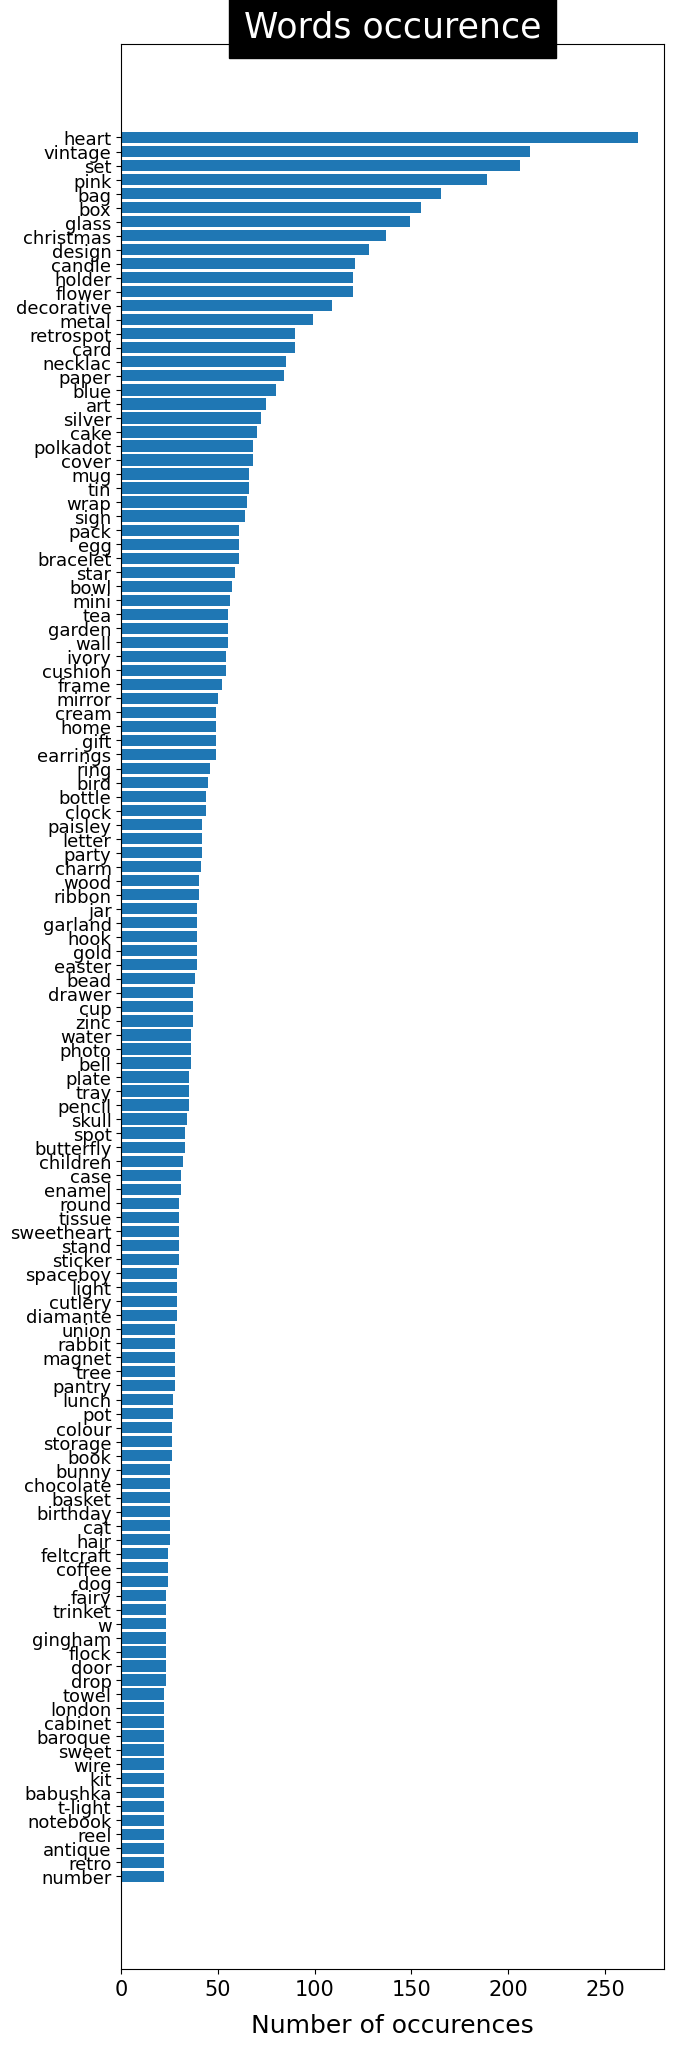

In [38]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Number of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

### Defining product categories 

The list that was obtained contains more than 1400 keywords and the most frequent ones appear in more than 200 products. However, while examining the content of the list, I note that some names are useless. Others are do not carry information, like colors. Therefore, I discard these words from the analysis that follows and also, I decide to consider only the words that appear more than 13 times.

In [39]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
 
list_products.sort(key = lambda x:x[1], reverse = True)
print('Preserved words:', len(list_products))

Preserved words: 193


#### Data encoding

Now I will use these keywords to create groups of product. Firstly, I define the $X$ matrix as:

   
|   | word  1  |  ...  | word j  | ...  | word N  |
|:-:|---|---|---|---|---|
| product 1  | $a_{1,1}$  |     |   |   | $a_{1,N}$  |
| ...        |            |     | ...  |   |   |
|product i   |    ...     |     | $a_{i,j}$    |   | ...  |
|...         |            |     |  ... |   |   |
| product M  | $a_{M,1}$  |     |   |   | $a_{M,N}$   |

where the $a_ {i, j}$ coefficient  is 1 if the description of the product $i$ contains the word $j$, and 0 otherwise.

In [40]:
liste_produits = df_cleaned['Description'].unique()
# print(liste_produits[0:2])
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
# print(X[0:1])

/tmp/ipykernel_8461/3479898938.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
/tmp/ipykernel_8461/3479898938.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
/tmp/ipykernel_8461/3479898938.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

In [41]:
X

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,...,tidy,plant,diner,house,square,craft,lace,jewel,wallet,point
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3874,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3875,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3876,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


* The $X$ matrix indicates the words contained in the description of the products using the *one-hot-encoding* principle. 



* In practice, I have found that introducing the price range results in more balanced groups in terms of element numbers.
Hence, I add 6 extra columns to this matrix, where I indicate the price range of the products:

In [42]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    #print(i)
    #print(col)
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    #print (prix)
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

/tmp/ipykernel_8461/1361581674.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, col] = 0
/tmp/ipykernel_8461/1361581674.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, col] = 0
/tmp/ipykernel_8461/1361581674.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, col]

and to choose the appropriate ranges, I check the number of products in the different groups:

In [43]:
print("{:<8} {:<20} \n".format('range', 'number of products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

range    number of products   
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


#### Creating clusters of products

In this section, I will group the products into different classes. In the case of matrices with binary encoding, the most suitable metric for the calculation of distances is the [Hamming's metric](https://en.wikipedia.org/wiki/Distance_de_Hamming). Note that the **kmeans** method of sklearn uses a Euclidean distance that can be used, but it is not to the best choice in the case of categorical variables. However, in order to use the Hamming's metric, we need to use the [kmodes](https://pypi.python.org/pypi/kmodes/) package which is not available on the current plateform. Hence, I use the **kmeans** method even if this is not the best choice.

In order to define (approximately) the number of clusters that best represents the data, I use the silhouette score:

In [44]:
matrix = X
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10071681758064248
For n_clusters = 4 The average silhouette_score is : 0.12609893747265383
For n_clusters = 5 The average silhouette_score is : 0.12666226252150753
For n_clusters = 6 The average silhouette_score is : 0.14544497724586775
For n_clusters = 7 The average silhouette_score is : 0.14116233607030118
For n_clusters = 8 The average silhouette_score is : 0.14597567867343827
For n_clusters = 9 The average silhouette_score is : 0.13689755255760092


In practice, the scores obtained above can be considered equivalent since, depending on the run, scores of $ 0.1 \pm 0.05 $ will be obtained for all clusters with `n_clusters` $> $ 3 (we obtain slightly lower scores for the first cluster). On the other hand, I found that beyond 5 clusters, some clusters contained very few elements. I therefore choose to separate the dataset into 5 clusters. In order to ensure a good classification at every run of the notebook, I iterate untill we obtain the best possible silhouette score, which is, in the present case, around 0.15:

In [45]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.1470081849157512


#### Characterizing the content of clusters

I check the number of elements in every class:

In [46]:
pd.Series(clusters).value_counts()

3    1009
4     964
0     673
2     626
1     606
Name: count, dtype: int64

** a: _Silhouette intra-cluster score_ **

In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters. This is the purpose of the next figure which is taken from the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html):

In [47]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    #plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        #color = cm.spectral(float(i) / n_clusters) facecolor=color, edgecolor=color,       
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, alpha=0.8)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
       
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

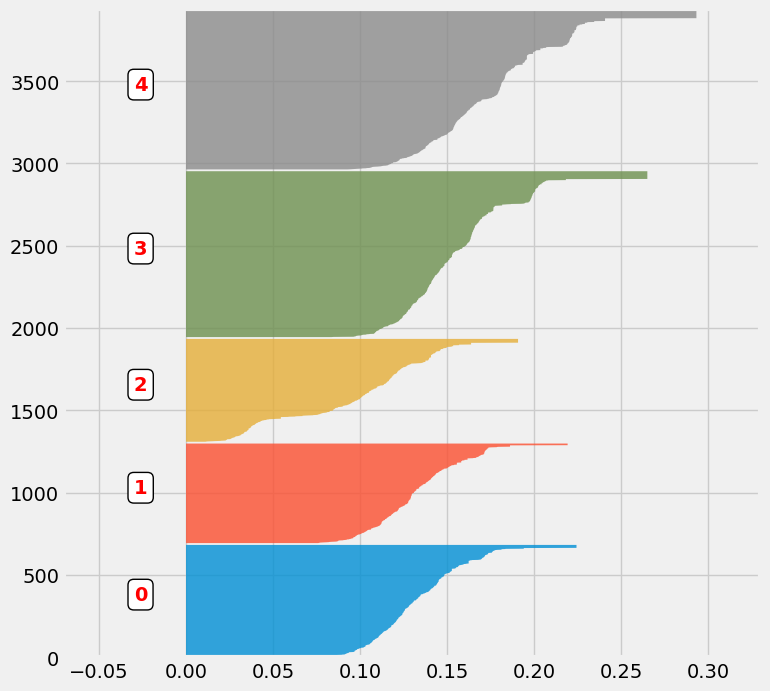

In [48]:

# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)

# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

** b: _Word Cloud_**

Now we can have a look at the type of objects that each cluster represents. In order to obtain a global view of their contents, I determine which keywords are the most frequent in each of them

In [49]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

and I output the result as wordclouds:

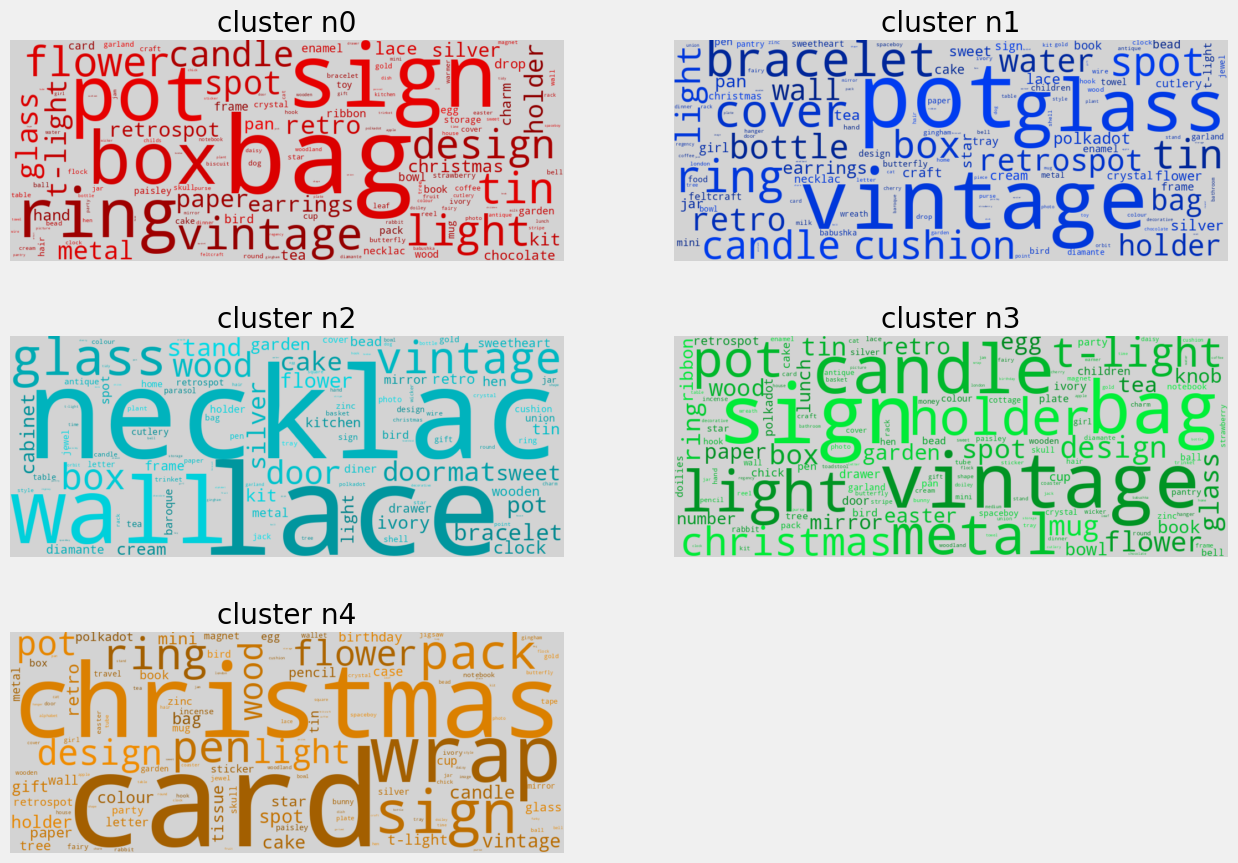

In [50]:

def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster n{}'.format(increment-1))

fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)            

From this representation, we can see that for example, one of the clusters contains objects that could be associated with gifts (keywords: Christmas, packaging, card, ...). Another cluster would rather contain luxury items and jewelry (keywords: necklace, bracelet, lace, silver, ...). Nevertheless, it can also be observed that many words appear in various clusters and it is therefore difficult to clearly distinguish them.

** c: _Principal Component Analysis_ **

In order to ensure that these clusters are truly distinct, I look at their composition. Given the large number of variables of the initial matrix, I first perform a PCA:

In [51]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

and then check for the amount of variance explained by each component:

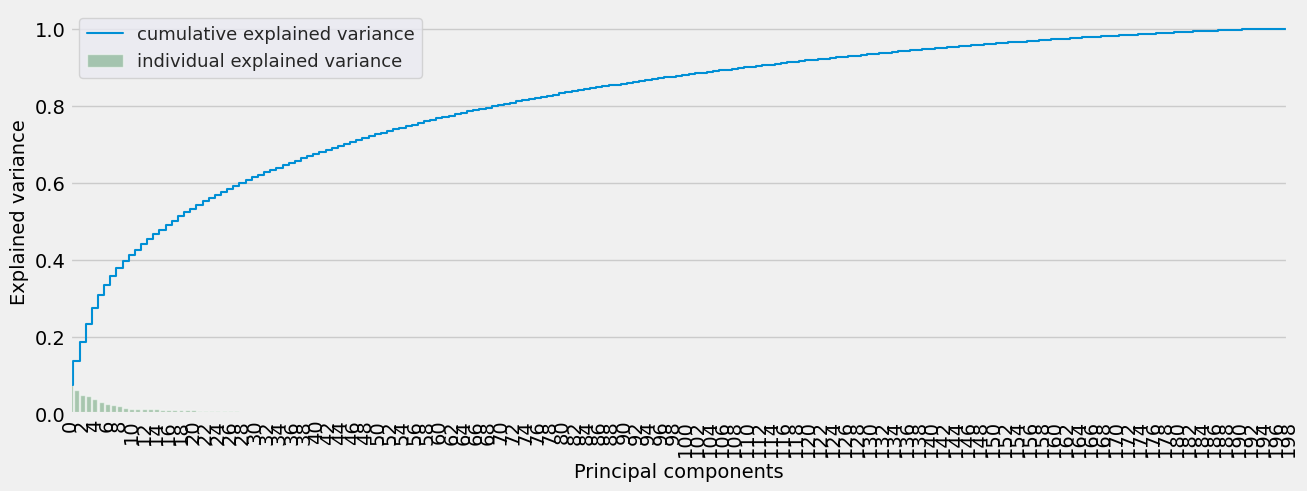

In [52]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)

# Plot cumulative explained variance
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')

# Plot individual explained variance
sns.barplot(x=np.arange(1, matrix.shape[1] + 1), y=pca.explained_variance_ratio_, alpha=0.5, color='g',
            label='individual explained variance')

plt.xlim(0, 100)

# Update x-tick labels
ticks = ax.get_xticks()  # Get the current tick positions
tick_labels = [int(tick) if int(tick) % 2 == 0 else '' for tick in ticks]
ax.set_xticks(ticks)  # Ensure we are setting labels for the existing ticks
ax.set_xticklabels(tick_labels)
plt.ylabel('Explained variance', fontsize=14)
plt.xlabel('Principal components', fontsize=14)
plt.xticks(rotation=90)
plt.legend(loc='upper left', fontsize=13)
plt.show()

We see that the number of components required to explain the data is extremely important: we need more than 100 components to explain 90% of the variance of the data. In practice, I decide to keep only a limited number of components since this decomposition is only performed to visualize the data:


In [53]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

In [54]:
mat

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,cluster
0,0.040415,-0.497231,0.088611,1.585314,-0.341039,-0.165409,0.682017,-1.027670,0.750717,0.222291,...,0.018054,-0.029618,0.032425,-0.169158,0.017587,-0.048058,0.047623,-0.049608,-0.024063,0
1,-0.018280,-0.422522,0.560010,-0.433862,-0.344758,-0.180222,-0.252112,0.004567,0.149674,-0.088444,...,0.007436,-0.025596,0.006512,-0.013826,-0.025635,-0.019292,0.058536,0.055190,-0.057209,1
2,0.015636,-0.315742,1.247444,0.749119,-0.505762,-0.011953,-0.163499,0.125233,-0.027569,-0.015317,...,-0.157475,-0.152956,-0.073995,-0.428628,-0.011245,-0.184861,-0.045817,-0.136237,0.024520,1
3,-0.035557,-0.467759,0.633836,-0.475281,-0.348023,-0.157524,-0.188462,-0.065911,-0.049834,-0.041866,...,-0.220251,-0.359327,0.162741,0.181306,0.854819,0.540891,0.350668,-0.432594,0.094681,1
4,0.008751,-0.319166,1.232738,0.739153,-0.492980,-0.010325,-0.144189,0.115459,-0.008467,0.004311,...,-0.016331,-0.068991,0.058323,-0.058993,0.006457,-0.089185,0.020256,0.010728,-0.011380,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3873,-0.728052,0.428815,-0.118997,-0.108651,-0.051229,-0.111369,-0.098357,-0.094791,-0.197318,-0.217531,...,-0.182845,0.037018,-0.066980,0.021434,0.100597,0.056370,-0.038543,0.066133,-0.161011,4
3874,-0.728052,0.428815,-0.118997,-0.108651,-0.051229,-0.111369,-0.098357,-0.094791,-0.197318,-0.217531,...,-0.182845,0.037018,-0.066980,0.021434,0.100597,0.056370,-0.038543,0.066133,-0.161011,4
3875,-0.700204,0.433657,-0.121753,-0.080156,-0.025287,-0.079470,-0.050170,-0.034466,-0.092798,-0.054068,...,0.419033,0.007002,0.185773,-0.050119,-0.059210,0.213674,-0.073451,-0.036251,0.180995,4
3876,0.046495,-0.508854,0.111872,1.599999,-0.339992,-0.166188,0.670420,-1.026272,0.741888,0.236819,...,-0.053441,-0.040392,-0.052793,-0.215646,0.048281,-0.080422,-0.017432,0.006219,0.090196,0


/tmp/ipykernel_8461/2067995319.py:34: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


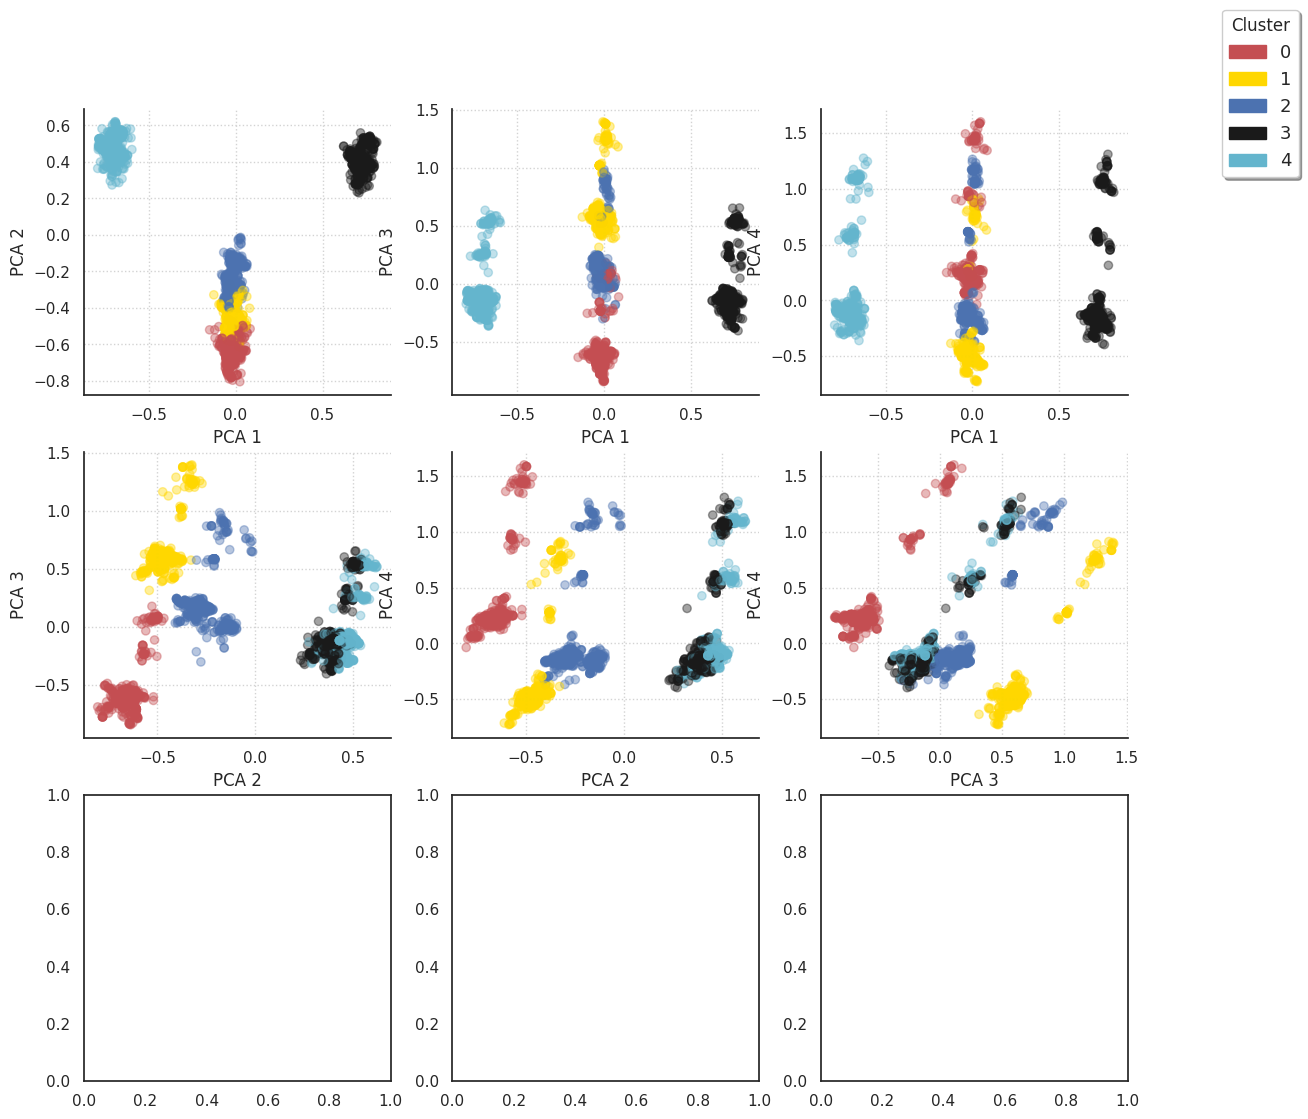

In [55]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0: 'r', 1: 'gold', 2: 'b', 3: 'k', 4: 'c', 5: 'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig, axes = plt.subplots(3, 3, figsize=(12, 12), gridspec_kw={'height_ratios': [1, 1, 1]})

increment = 0
for ix in range(4):
    for iy in range(ix + 1, 4):
        ax = axes[increment // 3, increment % 3]
        ax.scatter(mat[ix], mat[iy], c=label_color, alpha=0.4)
        ax.set_ylabel(f'PCA {iy + 1}', fontsize=12)
        ax.set_xlabel(f'PCA {ix + 1}', fontsize=12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        increment += 1
        if increment == 9: break
    if increment == 9: break

comp_handler = [mpatches.Patch(color=LABEL_COLOR_MAP[i], label=i) for i in range(5)]

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), title='Cluster',
           shadow=True, frameon=True, framealpha=1, fontsize=13,
           bbox_transform=plt.gcf().transFigure)

plt.tight_layout()
plt.show()


## Customer categories

Steps for generatin

* Formatting data 
  * Grouping products  
  * Splitting of the dataset 
  * Grouping orders  
* Creating customer categories 
  * Data encoding 
  * Creating categories 



### Formatting data

In the previous section, the different products were grouped in five clusters. In order to prepare the rest of the analysis, a first step consists in introducing this information into the dataframe. To do this, I create the categorical variable **categ_product** where I indicate the cluster of each product :

In [56]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 

df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)
df_cleaned[['InvoiceNo', 'Description', 
            'categ_product']][:10]

,InvoiceNo,Description,categ_product
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,0
1,536365,WHITE METAL LANTERN,1
2,536365,CREAM CUPID HEARTS COAT HANGER,1
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,1
4,536365,RED WOOLLY HOTTIE WHITE HEART.,1
5,536365,SET 7 BABUSHKA NESTING BOXES,2
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,1
7,536366,HAND WARMER UNION JACK,0
8,536366,HAND WARMER RED POLKA DOT,3
9,536367,ASSORTED COLOUR BIRD ORNAMENT,3


#### Grouping products

In a second step, I decide to create the **categ_N** variables (with $ N \in [0: 4]$) that contains the amount spent in each product category:

In [57]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)


df_cleaned[['InvoiceNo', 'Description', 
            'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:10]

/tmp/ipykernel_8461/1065481082.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(0, inplace = True)
/tmp/ipykernel_8461/1065481082.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,0,15.3,0.00,0.0,0.00,0.0
1,536365,WHITE METAL LANTERN,1,0.0,20.34,0.0,0.00,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,1,0.0,22.00,0.0,0.00,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,1,0.0,20.34,0.0,0.00,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,1,0.0,20.34,0.0,0.00,0.0
5,536365,SET 7 BABUSHKA NESTING BOXES,2,0.0,0.00,15.3,0.00,0.0
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,1,0.0,25.50,0.0,0.00,0.0
7,536366,HAND WARMER UNION JACK,0,11.1,0.00,0.0,0.00,0.0
8,536366,HAND WARMER RED POLKA DOT,3,0.0,0.00,0.0,11.10,0.0
9,536367,ASSORTED COLOUR BIRD ORNAMENT,3,0.0,0.00,0.0,54.08,0.0


Up to now, the information related to a single order was split over several lines of the dataframe (one line per product). I decide to collect the information related to a particular order and put in in a single entry. I therefore create a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the 5 categories of products:

In [58]:

# sum of purchases / user & order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

# percentage of the price of the order / product category
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp[col]

# date of the order

df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# selection of significant entries:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347,537626,711.79,83.40,293.35,124.44,187.2,23.40,2010-12-07 14:57:00.000000000
2,12347,542237,475.39,53.10,169.20,38.25,130.5,84.34,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,71.10,115.00,38.25,330.9,81.00,2011-04-07 10:43:00.000000000
4,12347,556201,382.52,78.06,168.76,19.90,74.4,41.40,2011-06-09 13:01:00.000000000
5,12347,562032,584.91,119.70,158.16,136.05,109.7,61.30,2011-08-02 08:48:00.000000000


#### Splitting of data over time

The dataframe `basket_price` contains information for a period of 12 months. Later, one of the objectives will be to develop a model capable of characterizing and anticipating the habits of the customers visiting the site and this, from their first visit. In order to be able to test the model in a realistic way, I split the data set by retaining the first 10 months to develop the model and the following two months to test it:

In [59]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [60]:
set_entrainement = basket_price[basket_price['InvoiceDate'] < pd.Timestamp(datetime.date(2011,10,1))]
set_test         = basket_price[basket_price['InvoiceDate'] >= pd.Timestamp(datetime.date(2011,10,1))]
basket_price = set_entrainement.copy(deep = True)

In [61]:
set_test

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
6,12347,573511,1294.32,435.90,368.72,132.10,203.30,154.30,2011-10-31 12:25:00.000000000
7,12347,581180,224.82,55.44,0.00,30.00,100.80,38.58,2011-12-07 15:52:00.000000000
12,12349,577609,1757.55,215.22,188.30,808.85,465.86,79.32,2011-11-21 09:51:00.000000000
21,12352,574275,311.73,27.23,22.50,133.90,107.30,20.80,2011-11-03 14:36:59.999999744
27,12356,576895,58.35,0.00,0.00,58.35,0.00,0.00,2011-11-17 08:40:00.000000000
...,...,...,...,...,...,...,...,...,...
18626,18283,578262,307.05,152.89,0.00,0.00,86.12,68.04,2011-11-23 13:27:00.000000000
18627,18283,579673,220.31,106.21,9.75,0.00,74.70,29.65,2011-11-30 12:59:00.000000000
18628,18283,580872,208.00,119.03,0.00,0.00,61.90,27.07,2011-12-06 12:02:00.000000000
18630,18287,570715,1001.32,326.04,32.00,0.00,386.44,256.84,2011-10-12 10:23:00.000000000


In [62]:
basket_price

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347,537626,711.79,83.40,293.35,124.44,187.20,23.40,2010-12-07 14:57:00.000000000
2,12347,542237,475.39,53.10,169.20,38.25,130.50,84.34,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,71.10,115.00,38.25,330.90,81.00,2011-04-07 10:43:00.000000000
4,12347,556201,382.52,78.06,168.76,19.90,74.40,41.40,2011-06-09 13:01:00.000000000
5,12347,562032,584.91,119.70,158.16,136.05,109.70,61.30,2011-08-02 08:48:00.000000000
...,...,...,...,...,...,...,...,...,...
18619,18283,557956,192.80,69.26,17.40,0.00,62.80,43.34,2011-06-23 19:20:00.000000000
18620,18283,560025,137.39,41.81,16.60,0.00,51.45,27.53,2011-07-14 13:00:00.000000000
18621,18283,560032,2.50,0.00,0.00,0.00,2.50,0.00,2011-07-14 13:20:00.000000000
18622,18283,565579,134.90,47.50,0.00,4.00,51.20,32.20,2011-09-05 12:35:00.000000000


#### Consumer Order Combinations

In a second step, I group together the different entries that correspond to the same user. I thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits:

In [63]:
# of visits and stats on cart amount / users
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])

for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() / transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,5,382.52,711.79,558.172000,2790.86,14.524555,32.408290,12.787815,29.836681,10.442659
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,0.000000,20.030714,41.953217,38.016069
2,12350,1,334.40,334.40,334.400000,334.40,27.900718,0.000000,11.961722,48.444976,11.692584
3,12352,6,144.35,840.30,345.663333,2073.98,3.370331,15.711338,67.534402,12.892120,0.491808
4,12353,1,89.00,89.00,89.000000,89.00,19.887640,0.000000,67.078652,13.033708,0.000000


Finally, I define two additional variables that give the number of days elapsed since the first purchase (** FirstPurchase **) and the number of days since the last purchase (** LastPurchase **):

In [64]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

/tmp/ipykernel_8461/1749811778.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
/tmp/ipykernel_8461/1749811778.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)


,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,5,382.52,711.79,558.172000,2790.86,14.524555,32.408290,12.787815,29.836681,10.442659,59,297
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,0.000000,20.030714,41.953217,38.016069,5,288
2,12350,1,334.40,334.40,334.400000,334.40,27.900718,0.000000,11.961722,48.444976,11.692584,240,240
3,12352,6,144.35,840.30,345.663333,2073.98,3.370331,15.711338,67.534402,12.892120,0.491808,2,226
4,12353,1,89.00,89.00,89.000000,89.00,19.887640,0.000000,67.078652,13.033708,0.000000,134,134


A customer category of particular interest is that of customers who make only one purchase. One of the objectives may be, for example, to target these customers in order to retain them. In part, I find that this type of customer represents 1/3 of the customers listed:

In [65]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("No. customers with single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

No. customers with single purchase: 1445/3608  (40.05%)


---
### Creation of customers categories

#### Data encoding

The dataframe `transactions_per_user` contains a summary of all the commands that were made. Each entry in this dataframe corresponds to a particular client. I use this information to characterize the different types of customers and only keep a subset of variables:

In [66]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols]

In practice, the different variables I selected have quite different ranges of variation and before continuing the analysis, I  create a matrix where these data are standardized:

In [67]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  3.62305987 259.93189634 556.26687999 377.06036244  21.19884856
  16.37327913  23.21847344  25.22916919  13.98907929]


In the following, I will create clusters of customers. In practice, before creating these clusters, it is interesting to define a base of smaller dimension allowing to describe the `scaled_matrix` matrix. In this case, I will use this base in order to create a representation of the different clusters and thus verify the quality of the separation of the different groups. I therefore perform a PCA beforehand:

In [68]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

and I represent the amount of variance explained by each of the components:

/tmp/ipykernel_8461/2902801353.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])


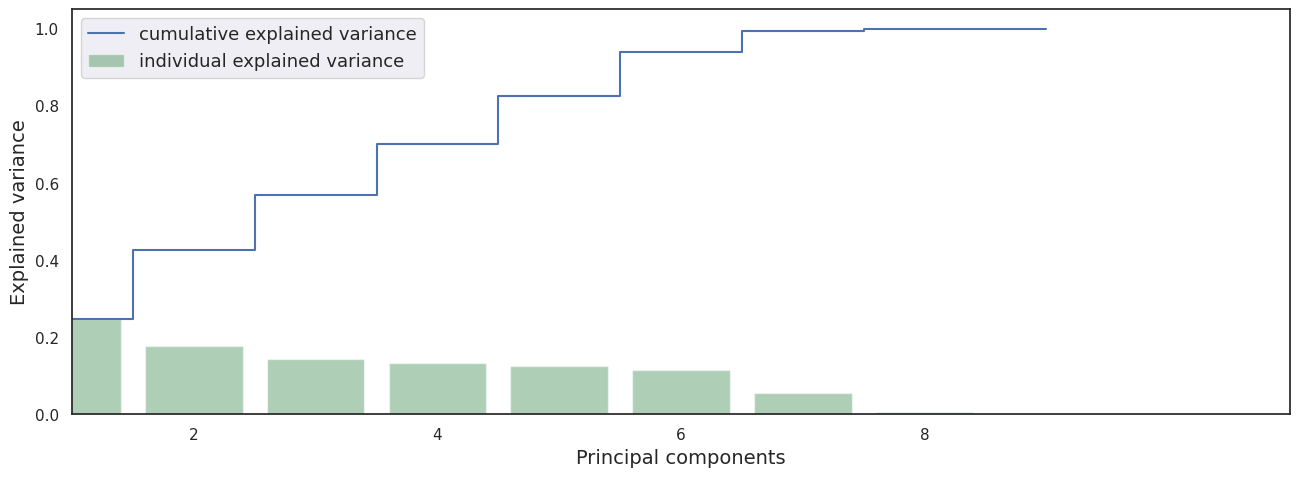

In [69]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(x=np.arange(1,matrix.shape[1]+1), y=pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

-----
#### Creating customer categories

At this point, I define clusters of clients from the standardized matrix that was defined earlier and using the `k-means` algorithm from` scikit-learn`. I choose the number of clusters based on the silhouette score and I find that the best score is obtained with 11 clusters:

In [70]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.217


In [71]:
clusters_clients

array([4, 1, 1, ..., 4, 4, 1], dtype=int32)

In [72]:
pd.DataFrame(pd.Series(clusters_clients).value_counts()).T

,4,5,1,10,8,0,3,9,7,2,6
count,1454,513,466,292,287,231,186,151,12,9,7


At first, I look at the number of customers in each cluster:

** a / _Report via the PCA_ **

There is a certain disparity in the sizes of different groups that have been created. Hence I will now try to understand the content of these clusters in order to validate (or not) this particular separation. At first, I use the result of the PCA:

In [73]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

in order to create a representation of the various clusters:

/tmp/ipykernel_8461/184519987.py:39: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


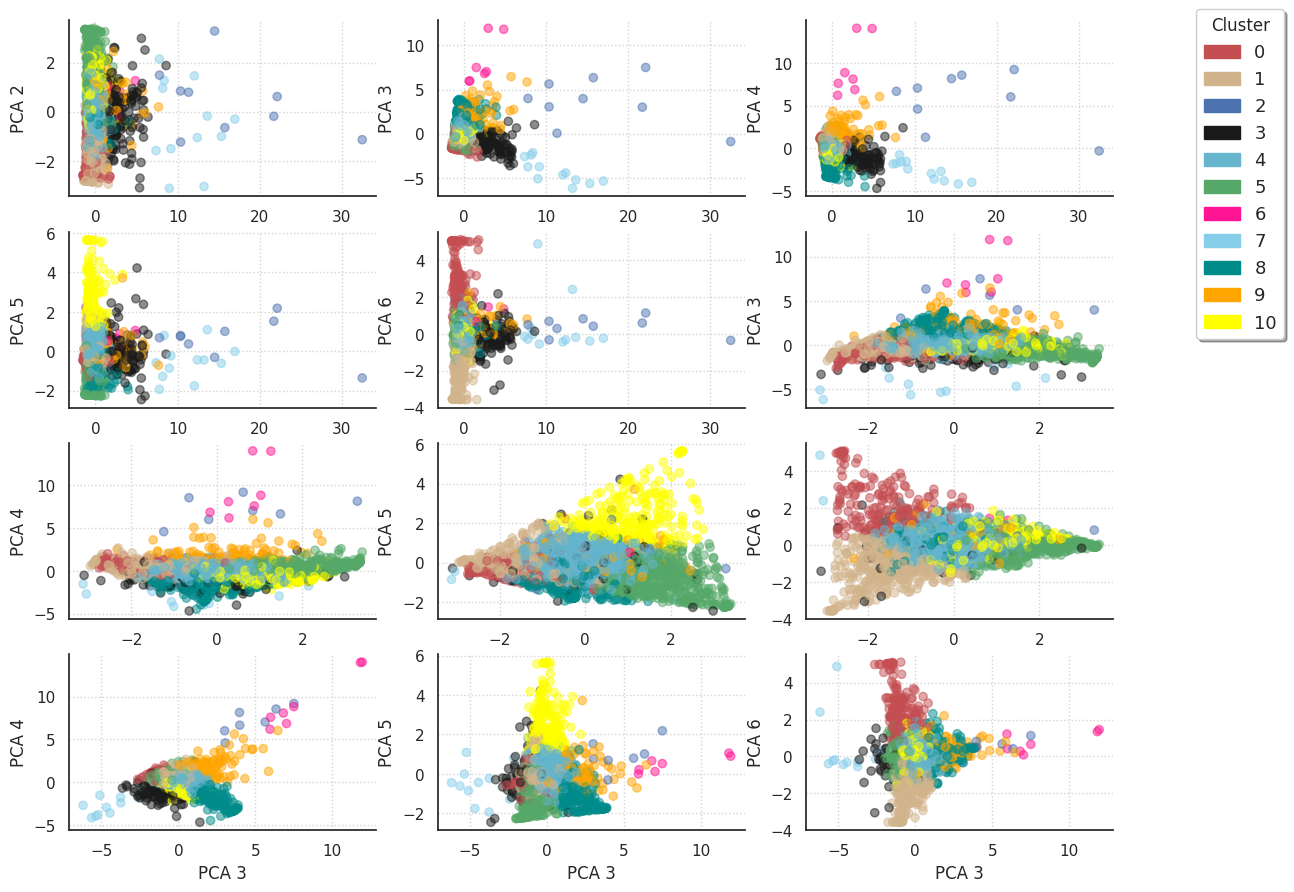

In [74]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan',
                   9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', 
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure) #facecolor = 'lightgrey',

plt.tight_layout()

From this representation, it can be seen, for example, that the first principal component allow to separate the tiniest clusters from the rest. More generally, we see that there is always a representation in which two clusters will appear to be distinct.

** b/ _Score of the silhouette intra-cluster_ **

As with product categories, another way to look at the quality of the separation is to look at silouhette scores within different clusters:

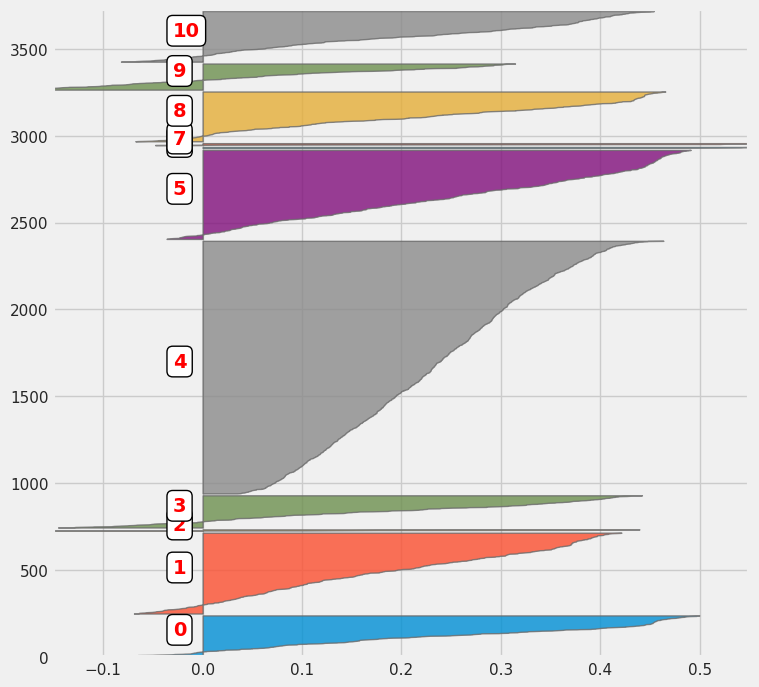

In [75]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silhouette scores 
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, 
                           clusters_clients)

** c/ _Customers morphotype_**

At this stage, I have verified that the different clusters are indeed disjoint (at least, in a global way). It remains to understand the habits of the customers in each cluster. To do so, I start by adding to the `selected_customers` dataframe a variable that defines the cluster to which each client belongs:

In [76]:
selected_customers.loc[:, 'cluster'] = clusters_clients

In [77]:
selected_customers

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,cluster
0,12347,5,382.52,711.79,558.172000,2790.86,14.524555,32.408290,12.787815,29.836681,10.442659,59,297,4
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,0.000000,20.030714,41.953217,38.016069,5,288,1
2,12350,1,334.40,334.40,334.400000,334.40,27.900718,0.000000,11.961722,48.444976,11.692584,240,240,1
3,12352,6,144.35,840.30,345.663333,2073.98,3.370331,15.711338,67.534402,12.892120,0.491808,2,226,5
4,12353,1,89.00,89.00,89.000000,89.00,19.887640,0.000000,67.078652,13.033708,0.000000,134,134,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3603,18280,1,180.60,180.60,180.600000,180.60,41.140642,24.833887,34.025471,0.000000,0.000000,207,207,4
3604,18281,1,80.82,80.82,80.820000,80.82,18.930958,0.000000,41.945063,20.415739,18.708241,110,110,5
3605,18282,1,98.76,98.76,98.760000,98.76,17.922236,13.669502,25.820170,23.238153,19.349939,56,56,4
3606,18283,10,2.50,192.80,108.683000,1086.83,34.907943,8.290165,2.792525,36.805204,17.204163,25,267,4


Then, I average the contents of this dataframe by first selecting the different groups of clients. This gives access to, for example, the average baskets price, the number of visits or the total sums spent by the clients of the different clusters. I also determine the number of clients in each group (variable ** size **):

In [78]:
selected_customers

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,cluster
0,12347,5,382.52,711.79,558.172000,2790.86,14.524555,32.408290,12.787815,29.836681,10.442659,59,297,4
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,0.000000,20.030714,41.953217,38.016069,5,288,1
2,12350,1,334.40,334.40,334.400000,334.40,27.900718,0.000000,11.961722,48.444976,11.692584,240,240,1
3,12352,6,144.35,840.30,345.663333,2073.98,3.370331,15.711338,67.534402,12.892120,0.491808,2,226,5
4,12353,1,89.00,89.00,89.000000,89.00,19.887640,0.000000,67.078652,13.033708,0.000000,134,134,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3603,18280,1,180.60,180.60,180.600000,180.60,41.140642,24.833887,34.025471,0.000000,0.000000,207,207,4
3604,18281,1,80.82,80.82,80.820000,80.82,18.930958,0.000000,41.945063,20.415739,18.708241,110,110,5
3605,18282,1,98.76,98.76,98.760000,98.76,17.922236,13.669502,25.820170,23.238153,19.349939,56,56,4
3606,18283,10,2.50,192.80,108.683000,1086.83,34.907943,8.290165,2.792525,36.805204,17.204163,25,267,4


In [79]:
merged_df = pd.DataFrame()

for i in range(n_clusters):
    # Select only numeric columns for mean calculation
    numeric_data = selected_customers[selected_customers['cluster'] == i].select_dtypes(include=['number'])
    
    # Calculate the mean for each cluster
    test = numeric_data.mean()
    
    # Convert the Series to DataFrame
    test = pd.DataFrame(test).T
    
    # Add the 'cluster' index and 'size' column
    test.index = [f"Cluster {i}"]
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    
    # Optionally, you can add CustomerID if needed
    customer_ids = selected_customers[selected_customers['cluster'] == i]['CustomerID'].tolist()
    test['CustomerIDs'] = [customer_ids]  # Store as a list of CustomerIDs
    
    # Append to merged_df
    merged_df = pd.concat([merged_df, test])

# Sort the DataFrame by the 'sum' column (make sure there's a column named 'sum')
merged_df = merged_df.sort_values('sum')

print('Number of customers:', merged_df['size'].sum())


Number of customers: 3608


Finally, I re-organize the content of the dataframe by ordering the different clusters: first, in relation to the amount wpsent in each product category and then, according to the total amount spent:

In [80]:
merged_df

,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,cluster,size,CustomerIDs
Cluster 0,2.199134,193.774026,317.699913,247.165261,582.228312,11.101421,6.026141,7.249538,18.052858,57.570041,99.493506,167.766234,0.0,231,"[12395, 12399, 12455, 12599, 12619, 12651, 126..."
Cluster 10,2.123288,203.776918,335.356712,262.935284,647.509589,13.518038,51.292576,15.428503,13.489404,6.324525,109.825342,169.301370,10.0,292,"[12429, 12492, 12509, 12535, 12614, 12664, 127..."
Cluster 1,2.454936,213.901824,332.311075,269.482427,676.670260,12.833347,7.750328,9.567472,57.044069,12.807978,101.776824,174.493562,1.0,466,"[12348, 12350, 12355, 12361, 12364, 12372, 123..."
Cluster 5,2.604288,199.956337,344.859864,262.231575,706.745363,10.896564,11.025822,62.119264,11.171983,4.797367,115.865497,188.366472,5.0,513,"[12352, 12353, 12358, 12359, 12365, 12384, 124..."
Cluster 8,2.578397,211.335679,375.124774,288.734799,812.509652,61.314523,6.871253,10.015622,14.810284,6.988318,103.170732,194.965157,8.0,287,"[12373, 12380, 12402, 12494, 12516, 12527, 125..."
Cluster 4,3.271664,218.302559,457.291294,329.438996,1088.828034,22.334075,17.445713,20.634846,25.589054,14.000388,81.947730,198.091472,4.0,1454,"[12347, 12360, 12362, 12363, 12370, 12375, 123..."
Cluster 3,1.715054,1043.058710,1408.034199,1208.009045,2195.958177,21.241679,17.315895,23.153352,26.249404,12.040033,94.913978,142.478495,3.0,186,"[12354, 12356, 12377, 12381, 12397, 12405, 124..."
Cluster 7,1.666667,3480.920833,3966.812500,3700.139306,5949.600000,13.322062,15.171169,28.513409,20.102624,22.890736,68.166667,132.583333,7.0,12,"[12378, 12409, 12435, 12451, 12477, 12688, 127..."
Cluster 9,18.271523,87.902781,1629.672715,582.572769,10059.916954,25.546983,16.123242,22.001596,24.043616,12.305314,17.205298,279.695364,9.0,151,"[12428, 12471, 12474, 12540, 12569, 12621, 126..."
Cluster 6,92.000000,10.985714,1858.250000,374.601553,34845.105714,22.527857,13.402971,25.144909,25.832531,13.117583,1.428571,302.285714,6.0,7,"[12748, 12971, 13089, 14606, 14911, 15311, 17841]"


In [81]:
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])

liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]

merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,8.0,2.578397,211.335679,375.124774,288.734799,812.509652,61.314523,6.871253,10.015622,14.810284,6.988318,287
1,10.0,2.123288,203.776918,335.356712,262.935284,647.509589,13.518038,51.292576,15.428503,13.489404,6.324525,292
2,5.0,2.604288,199.956337,344.859864,262.231575,706.745363,10.896564,11.025822,62.119264,11.171983,4.797367,513
3,1.0,2.454936,213.901824,332.311075,269.482427,676.670260,12.833347,7.750328,9.567472,57.044069,12.807978,466
4,0.0,2.199134,193.774026,317.699913,247.165261,582.228312,11.101421,6.026141,7.249538,18.052858,57.570041,231
5,4.0,3.271664,218.302559,457.291294,329.438996,1088.828034,22.334075,17.445713,20.634846,25.589054,14.000388,1454
6,3.0,1.715054,1043.058710,1408.034199,1208.009045,2195.958177,21.241679,17.315895,23.153352,26.249404,12.040033,186
7,7.0,1.666667,3480.920833,3966.812500,3700.139306,5949.600000,13.322062,15.171169,28.513409,20.102624,22.890736,12
8,9.0,18.271523,87.902781,1629.672715,582.572769,10059.916954,25.546983,16.123242,22.001596,24.043616,12.305314,151
9,6.0,92.000000,10.985714,1858.250000,374.601553,34845.105714,22.527857,13.402971,25.144909,25.832531,13.117583,7


____

## Classification of customers

In this part, the objective will be to adjust a classifier that will classify consumers in the different client categories that were established in the previous section. The objective is to make this classification possible at the first visit. To fulfill this objective, I will test several classifiers implemented in `scikit-learn`. First, in order to simplify their use, I define a class that allows to interface several of the functionalities common to these different classifiers: 

In [82]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))
        

Since the goal is to define the class to which a client belongs and this, as soon as its first visit, I only keep the variables that describe the content of the basket, and do not take into account the variables related to the frequency of visits or variations of the basket price over time:

In [83]:
selected_customers.head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,cluster
0,12347,5,382.52,711.79,558.172000,2790.86,14.524555,32.408290,12.787815,29.836681,10.442659,59,297,4
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,0.000000,20.030714,41.953217,38.016069,5,288,1
2,12350,1,334.40,334.40,334.400000,334.40,27.900718,0.000000,11.961722,48.444976,11.692584,240,240,1
3,12352,6,144.35,840.30,345.663333,2073.98,3.370331,15.711338,67.534402,12.892120,0.491808,2,226,5
4,12353,1,89.00,89.00,89.000000,89.00,19.887640,0.000000,67.078652,13.033708,0.000000,134,134,5


In [84]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

Finally, I split the dataset in train and test sets:

In [85]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

___
### Support Vector Machine Classifier (SVC)

The first classifier I use is the SVC classifier. In order to use it, I create an instance of the `Class_Fit` class and then call` grid_search()`. When calling this method, I provide as parameters:
- the hyperparameters for which I will seek an optimal value
- the number of folds to be used for cross-validation

In [86]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

Once this instance is created, I adjust the classifier to the training data:

In [87]:
svc.grid_fit(X = X_train, Y = Y_train)

then I can test the quality of the prediction with respect to the test data:

In [88]:
svc.grid_predict(X_test, Y_test)

Precision: 87.40 % 


Note that for every run precision value may change

___
#### Confusion matrix

The accuracy of the results seems to be correct. Nevertheless, let us remember that when the different classes were defined, there was an imbalance in size between the classes obtained. In particular, one class contains around 40% of the clients. It is therefore interesting to look at how the predictions and real values compare to the breasts of the different classes. This is the subject of the confusion matrices and to represent them, I use the code of the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html):

In [89]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
   
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from which I create the following representation:

Confusion matrix, without normalization


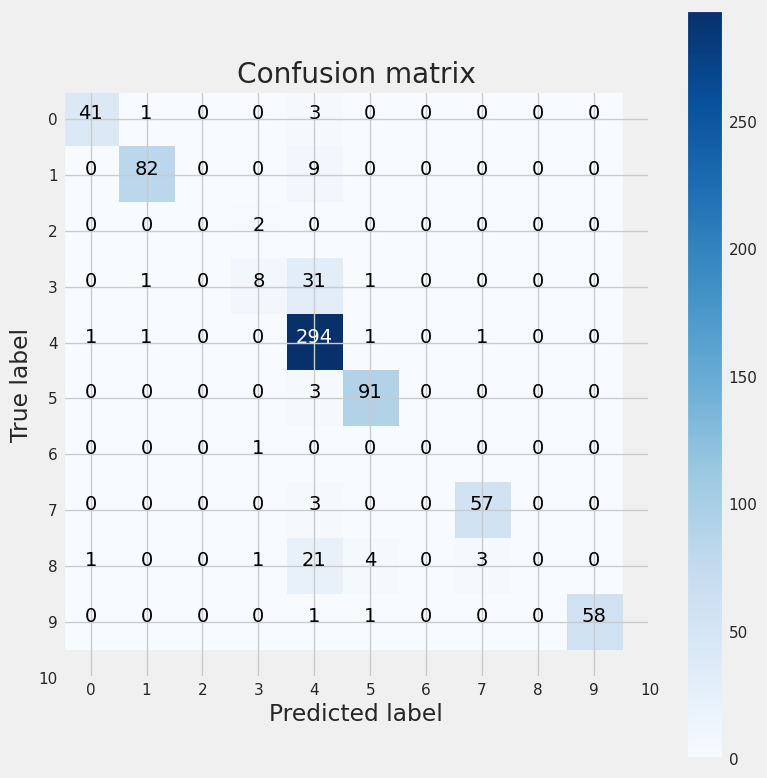

In [90]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')


----------------
#### Learning curve

A typical way to test the quality of a fit is to draw a learning curve. In particular, this type of curves allow to detect possible drawbacks in the model, linked for example to over- or under-fitting. This also shows to which extent the mode could benefit from a larger data sample. In order to draw this curve, I use the [scikit-learn documentation code again](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr- self-examples-model-selection-pad-learning-curve-py)

In [91]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

from which I represent the leanring curve of the SVC classifier:

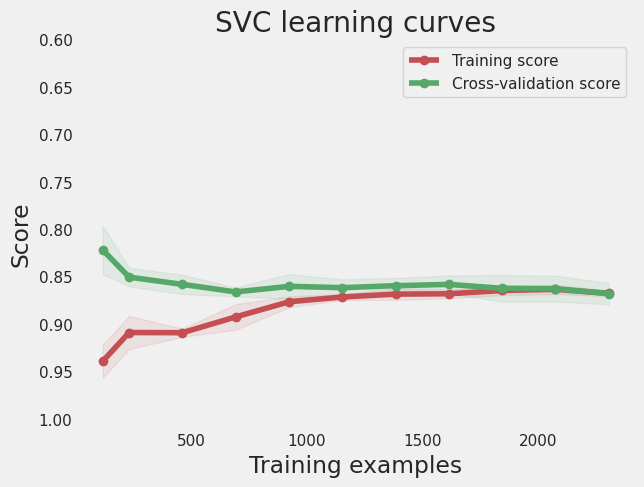

In [92]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

On this curve, we can see that the train and cross-validation curves converge towards the same limit when the sample size increases. This is typical of modeling with low variance and proves that the model does not suffer from overfitting. Also, we can see that the accuracy of the training curve is correct which is synonymous of a low bias. Hence the model does not underfit the data.

___

## Revised approach

### Logistic Regression

I now consider the logistic regression classifier. As before, I create an instance of the `Class_Fit` class, adjust the model on the training data and see how the predictions compare to the real values:

In [93]:
lr = Class_Fit(clf = linear_model.LogisticRegression, params={'max_iter': 500})
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

/home/riziuzi/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/riziuzi/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Precision: 91.27 % 


/home/riziuzi/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Then, I plot the learning curve to have a feeling of the quality of the model:

/home/riziuzi/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/riziuzi/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

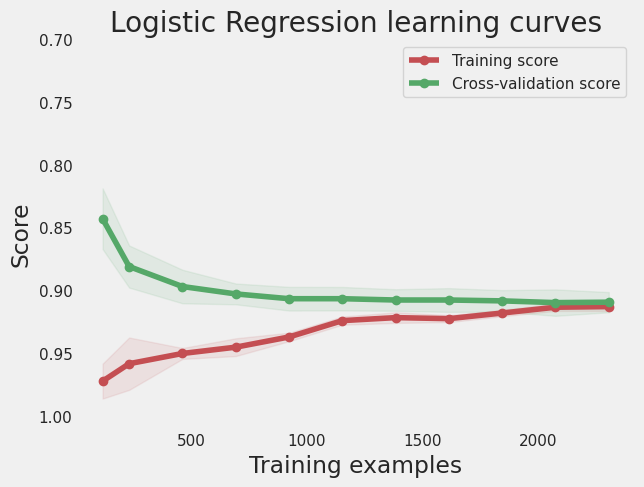

In [94]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

----
### k-Nearest Neighbors

In [95]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 78.53 % 


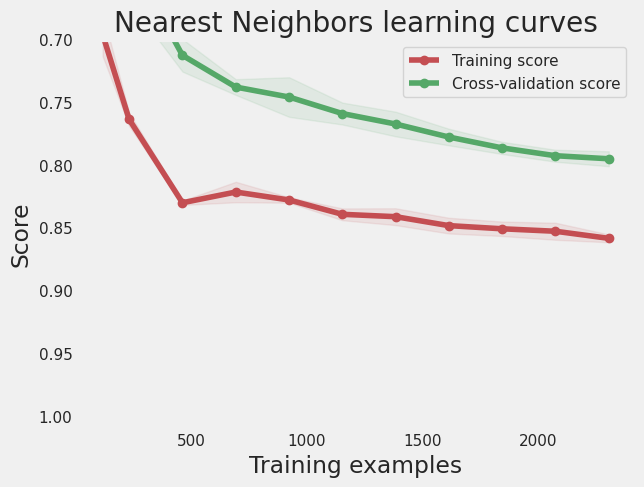

In [96]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Decision Tree

In [97]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 84.63 % 


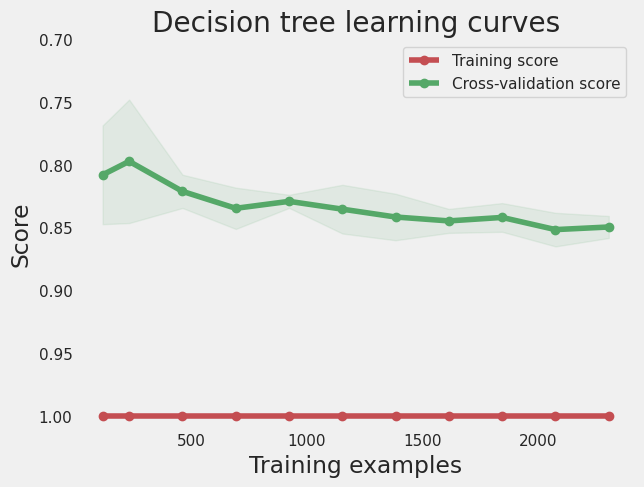

In [98]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Random Forest

In [99]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 90.30 % 


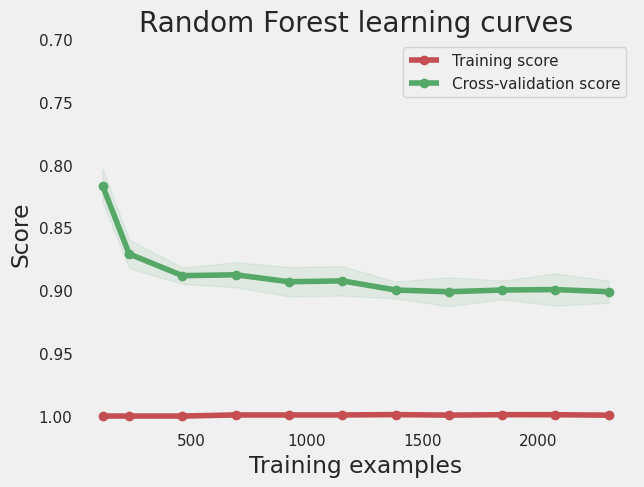

In [100]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### AdaBoost Classifier

In [101]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

/home/riziuzi/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/riziuzi/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/riziuzi/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/riziuzi/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Precision: 53.88 % 


/home/riziuzi/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


/home/riziuzi/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/riziuzi/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/riziuzi/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/riziuzi/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

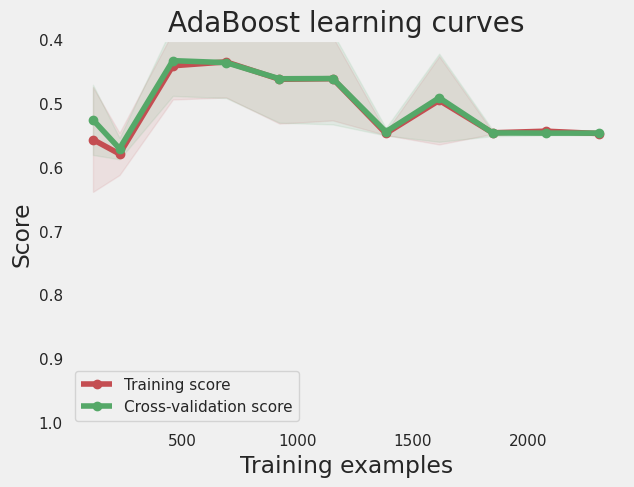

In [102]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

###  Gradient Boosting Classifier

In [103]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 89.34 % 


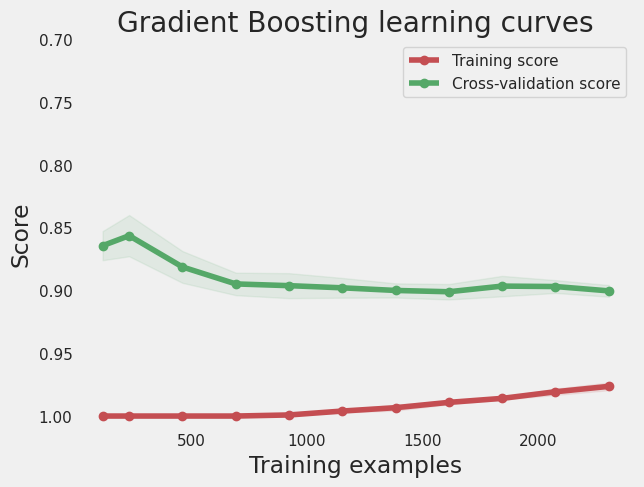

In [104]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

------
## Best approach
### Let's vote !

Finally, the results of the different classifiers presented in the previous sections can be combined to improve the classification model. This can be achieved by selecting the customer category as the one indicated by the majority of classifiers. To do this, I use the `VotingClassifier` method of the `sklearn` package. As a first step, I adjust the parameters of the various classifiers using the *best* parameters previously found:

In [105]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

Then, I define a classifier that merges the results of the various classifiers:

In [106]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft')    

and train it:

In [107]:
votingC = votingC.fit(X_train, Y_train)

Finally, we can create a prediction for this model:

In [108]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 91.00 % 


Note that when defining the `votingC` classifier, I only used a sub-sample of the whole set of classifiers defined above and only retained the *Random Forest*, the *k-Nearest Neighbors* and the *Gradient Boosting* classifiers. In practice, this choice has been done with respect to the performance of the classification carried out in the next section.

___
## Testing predictions

In the previous section, a few classifiers were trained in order to categorize customers. Until that point, the whole analysis was based on the data of the first 10 months. In this section, I test the model  the last two months of the dataset, that has been stored in the `set_test` dataframe:

In [109]:
set_test

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
6,12347,573511,1294.32,435.90,368.72,132.10,203.30,154.30,2011-10-31 12:25:00.000000000
7,12347,581180,224.82,55.44,0.00,30.00,100.80,38.58,2011-12-07 15:52:00.000000000
12,12349,577609,1757.55,215.22,188.30,808.85,465.86,79.32,2011-11-21 09:51:00.000000000
21,12352,574275,311.73,27.23,22.50,133.90,107.30,20.80,2011-11-03 14:36:59.999999744
27,12356,576895,58.35,0.00,0.00,58.35,0.00,0.00,2011-11-17 08:40:00.000000000
...,...,...,...,...,...,...,...,...,...
18626,18283,578262,307.05,152.89,0.00,0.00,86.12,68.04,2011-11-23 13:27:00.000000000
18627,18283,579673,220.31,106.21,9.75,0.00,74.70,29.65,2011-11-30 12:59:00.000000000
18628,18283,580872,208.00,119.03,0.00,0.00,61.90,27.07,2011-12-06 12:02:00.000000000
18630,18287,570715,1001.32,326.04,32.00,0.00,386.44,256.84,2011-10-12 10:23:00.000000000


In [110]:
basket_price = set_test.copy(deep = True)

In [111]:
basket_price

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
6,12347,573511,1294.32,435.90,368.72,132.10,203.30,154.30,2011-10-31 12:25:00.000000000
7,12347,581180,224.82,55.44,0.00,30.00,100.80,38.58,2011-12-07 15:52:00.000000000
12,12349,577609,1757.55,215.22,188.30,808.85,465.86,79.32,2011-11-21 09:51:00.000000000
21,12352,574275,311.73,27.23,22.50,133.90,107.30,20.80,2011-11-03 14:36:59.999999744
27,12356,576895,58.35,0.00,0.00,58.35,0.00,0.00,2011-11-17 08:40:00.000000000
...,...,...,...,...,...,...,...,...,...
18626,18283,578262,307.05,152.89,0.00,0.00,86.12,68.04,2011-11-23 13:27:00.000000000
18627,18283,579673,220.31,106.21,9.75,0.00,74.70,29.65,2011-11-30 12:59:00.000000000
18628,18283,580872,208.00,119.03,0.00,0.00,61.90,27.07,2011-12-06 12:02:00.000000000
18630,18287,570715,1001.32,326.04,32.00,0.00,386.44,256.84,2011-10-12 10:23:00.000000000


In a first step, I regroup reformattes these data according to the same procedure as used on the training set. However, I am correcting the data to take into account the difference in time between the two datasets and weights the variables ** count ** and ** sum ** to obtain an equivalence with the training set:

In [112]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()

#_______________________
# Correcting time range
transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,10,224.82,1294.32,759.57,7595.70,32.343299,24.271627,10.670511,20.017905,12.696657
1,12349,5,1757.55,1757.55,1757.55,8787.75,12.245455,10.713778,46.021450,26.506216,4.513101
2,12352,5,311.73,311.73,311.73,1558.65,8.735123,7.217785,42.953838,34.420813,6.672441
3,12356,5,58.35,58.35,58.35,291.75,0.000000,0.000000,100.000000,0.000000,0.000000
4,12357,5,6207.67,6207.67,6207.67,31038.35,14.684737,28.350089,33.399810,18.475531,5.089832


Then, I convert the dataframe into a matrix and retain only variables that define the category to which consumers belong. At this level, I recall the method of normalization that had been used on the training set:

In [113]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
matrix_test = transactions_per_user[list_cols]
scaled_test_matrix = scaler.transform(matrix_test)


Each line in this matrix contains a consumer's buying habits. At this stage, it is a question of using these habits in order to define the category to which the consumer belongs. These categories have been established in Section 4. ** At this stage, it is important to bear in mind that this step does not correspond to the classification stage itself**. Here, we prepare the test data by defining the category to which the customers belong. However, this definition uses data obtained over a period of 2 months (via the variables ** count **, ** min **, ** max ** and ** sum **). The classifier defined in Section 5 uses a more restricted set of variables that will be defined from the first purchase of a client.

Here it is a question of using the available data over a period of two months and using this data to define the category to which the customers belong. Then, the classifier can be tested by comparing its predictions with these categories. In order to define the category to which the clients belong, I recall the instance of the `kmeans` method used in section 4. The` predict` method of this instance calculates the distance of the consumers from the centroids of the 11 client classes and the smallest distance will define the belonging to the different categories:

In [114]:
Y = kmeans.predict(scaled_test_matrix)

Finally, in order to prepare the execution of the classifier, it is sufficient to select the variables on which it acts:

In [115]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transactions_per_user[columns]

It remains only to examine the predictions of the different classifiers that have been trained earlier

In [116]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 71.03 % 
______________________________ 
Logostic Regression
Precision: 75.46 % 
______________________________ 
k-Nearest Neighbors
Precision: 67.89 % 
______________________________ 
Decision Tree
Precision: 71.38 % 
______________________________ 
Random Forest
Precision: 74.99 % 
______________________________ 
Gradient Boosting
Precision: 74.75 % 


Finally, as anticipated in revised approach, it is possible to improve the quality of the classifier by combining their respective predictions. At this level, I chose to mix *Random Forest*, *Gradient Boosting* and *k-Nearest Neighbors* predictions because this leads to a slight improvement in predictions:

In [117]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 75.58 % 
